**PROBLEM STATEMENT :**

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

**IMPORT LIBRARIES AND DATASET** **:** 

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import xgboost as xgb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 **IMPORT SALES TRAINING DATA** **:** 

In [4]:
sales_train_df = pd.read_csv('/content/drive/MyDrive/DiplomaProject/train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
sales_train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
sales_train_df.shape

(1017209, 9)

************************************************************************
************************************************************************



We can see that there are a total of 1017209 observations.

There are 9 columns in total and note that sales is the target variable.

--Id: an Id that represents a (Store, Date) duple within the test set 

--Store: a unique Id for each store

--Sales: sales/day, this is the target variable

--Customers: number of customers on a given day

--Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)

--Promo: describes if store is running a promo on that day or not

--StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)

--SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
************************************************************************
************************************************************************



In [7]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


************************************************************************
************************************************************************

We can infer the following observations from the describe function results :

--Average sales amount per day = 5773 Euros

--minimum sales per day = 0

--maximum sales per day = 41551 

--Average number of customers = 633

--minimum number of customers = 0

--maximum number of customers = 7388
************************************************************************
************************************************************************



**IMPORT STORE DATA** **:** 

In [9]:
store_info_df = pd.read_csv('/content/drive/MyDrive/DiplomaProject/store.csv')

In [10]:
store_info_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


************************************************************************
************************************************************************

--StoreType: categorical variable to indicate type of store (a, b, c, d)

--Assortment: describes an assortment level: a = basic, b = extra, c = extended

--CompetitionDistance (meters): distance to closest competitor store

--CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open

--Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)

--Promo2Since [Year/Week]: date when the store started participating in Promo2

--PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
************************************************************************
************************************************************************



In [11]:
store_info_df.shape

(1115, 10)

In [12]:
store_info_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


************************************************************************
************************************************************************

This dataframe only includes information about the unique 1115 stores that are part of this study and does not contain information about transaction sales per day.
************************************************************************
************************************************************************



In [13]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


************************************************************************
************************************************************************

on average, the competition distance is 5404 meters away (5.4 kms)
************************************************************************
************************************************************************



**EDA OF DATASETS** **:**

**EDA OF SALES TRAINING DATA** **:** 

In [14]:
#check for any missing data 
sales_train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

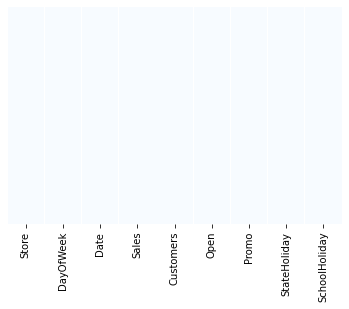

In [15]:
#sns heatmap of missing data 
sns.heatmap(sales_train_df.isnull(), yticklabels = False,cbar = False, cmap = "Blues")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febcaedee10>,
      dtype=object)

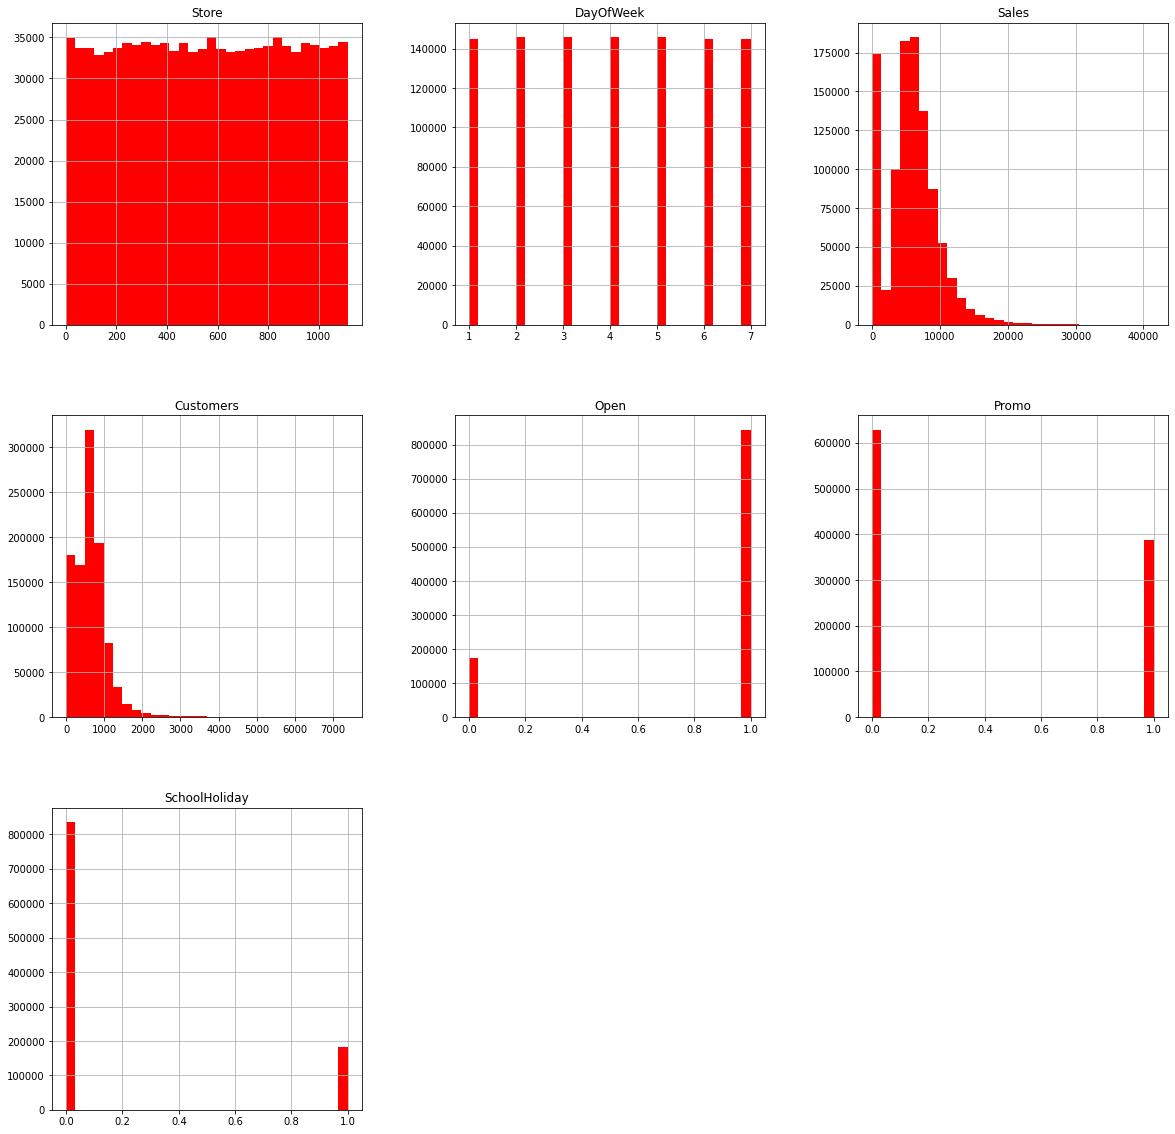

In [16]:
#sales train dataframe histogram
sales_train_df.hist(bins = 30, figsize = (20,20), color = 'r')

************************************************************************
************************************************************************

We can infer the following from the dataframe histogram function :

--Data is equally distributed among all stores

--Data is equally distibuted across various Days of the week

--Stores are open  approximately 80% of the time

--Promo1 was running approximately 40% of the time 

--Average sales is around 5000-6000 Euros

--School holidays are around 18% of the time
************************************************************************
************************************************************************



In [17]:
# how many stores are open and closed with relation to sales
closed_train_zero_sales_df        = sales_train_df[(sales_train_df.Open == 0) & (sales_train_df.Sales == 0)]
closed_train_non_zero_sales_df         = sales_train_df[(sales_train_df.Open == 0) & (sales_train_df.Sales != 0)]
open_train_zero_sales_df        = sales_train_df[(sales_train_df.Open == 1) & (sales_train_df.Sales == 0)]
open_train_non_zero_sales_df        = sales_train_df[(sales_train_df.Open == 1) & (sales_train_df.Sales != 0)]

In [18]:
# Count the number of stores that are open and closed
print("Total =", len(sales_train_df))
print("Number of closed stores with zero sales  =", len(closed_train_zero_sales_df))
print("Number of closed stores with non zero sales =", len(closed_train_non_zero_sales_df))
print("Number of open stores with zero sales =", len(open_train_zero_sales_df))
print("Number of open stores with non zero sales =", len(open_train_non_zero_sales_df))


Total = 1017209
Number of closed stores with zero sales  = 172817
Number of closed stores with non zero sales = 0
Number of open stores with zero sales = 54
Number of open stores with non zero sales = 844338


************************************************************************
************************************************************************

There are 172817 closed stores in the data which is a significant amount of observations.Also, there are 54 rows with open store but no sales on working days. We will drop these rows as these rows do not have any meaningful contribution and may create bias while forecasting.
************************************************************************
************************************************************************



In [19]:
#  remove closed stores and zero sales rows
sales_train_df = sales_train_df[(sales_train_df['Open'] != 0) & (sales_train_df['Sales'] != 0)]

In [20]:
# drop the open column since it has no meaning now
sales_train_df.drop(['Open'], axis=1, inplace=True)

In [21]:
sales_train_df.shape

(844338, 8)

In [22]:
sales_train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


**EDA OF STORES INFORMATION DATA** **:** 

In [23]:
#check for any missing data 
store_info_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

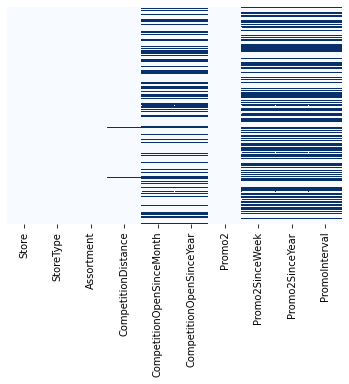

In [24]:
#sns heatmap of missing data
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

************************************************************************
************************************************************************

Let us first start with the missing values in the 'CompetitionDistance' as ony 3 rows are missing
************************************************************************
************************************************************************



In [25]:
store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


************************************************************************
************************************************************************

For this feature, let us fill the missing rows with the average values of the 'CompetitionDistance' column.
************************************************************************
************************************************************************



In [26]:
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

************************************************************************
************************************************************************

Let us look at the missing values in the 'CompetitionOpenSinceMonth' feature in which 354 rows are missing which constitutes almost one third of the store count.
************************************************************************
************************************************************************



In [27]:
store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


************************************************************************
************************************************************************

Let us check the rows with 'Promo2' equals 0
************************************************************************
************************************************************************



In [28]:
store_info_df[ store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


************************************************************************
************************************************************************

We can infer that, if 'promo2' feature is zero, values in features 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' is also set to zero

And there are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' feature values are missing

We will set these values to zeros 
************************************************************************
************************************************************************



In [29]:
column_features = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for str in column_features:
    store_info_df [str].fillna(0, inplace = True)

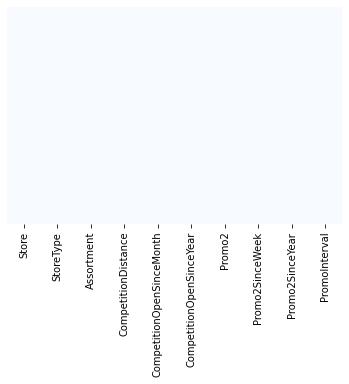

In [30]:
#sns heatmap of missing values shows there are no missing values now
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

**EDA OF MERGED DATASET** **:** 

************************************************************************
************************************************************************

We will merge the sales_train_df and store_info_df data frames together based on 'store' column
************************************************************************
************************************************************************



In [31]:
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store') 
#sales_train_all_df.to_csv('test.csv', index=False)

In [32]:
sales_train_all_df.shape

(844338, 17)

In [33]:
sales_train_all_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


************************************************************************
************************************************************************

Let us check the correlations with respect to sales by plotting the seaborn heatmap :
************************************************************************
************************************************************************



In [34]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations 

DayOfWeek                   -0.178753
Promo2SinceYear             -0.127581
Promo2                      -0.127556
Promo2SinceWeek             -0.058493
CompetitionDistance         -0.036401
CompetitionOpenSinceMonth   -0.018369
CompetitionOpenSinceYear     0.005257
Store                        0.007723
SchoolHoliday                0.038635
Promo                        0.368199
Customers                    0.823552
Sales                        1.000000
Name: Sales, dtype: float64

************************************************************************
************************************************************************

We can infer that customers and promo are positively correlated with the sales 

Also, Promo2 does not seem to be effective at all
************************************************************************
************************************************************************



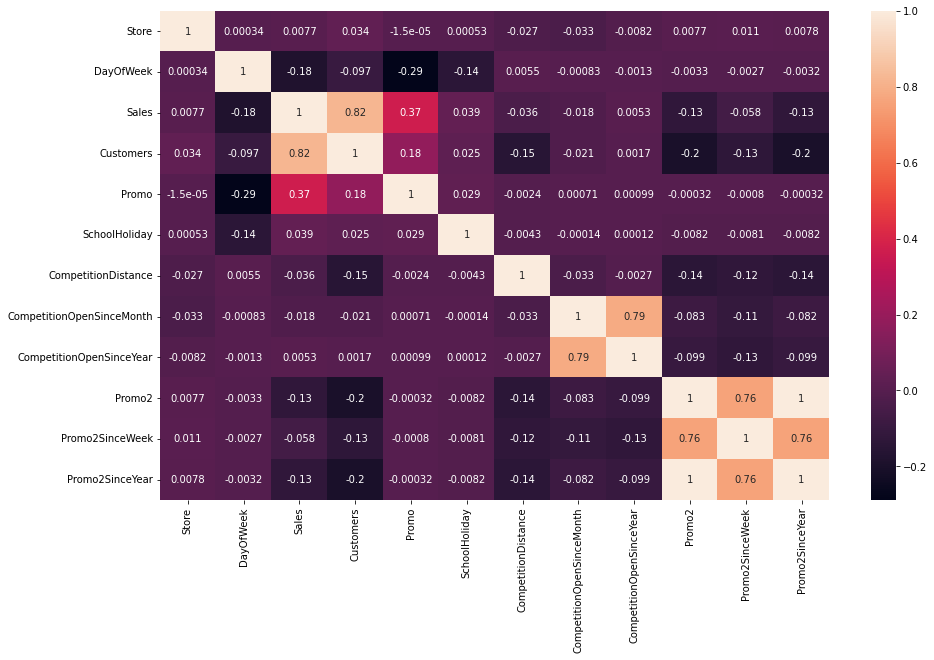

In [35]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize = (15, 9))
sns.heatmap(correlations, annot = True)

************************************************************************
************************************************************************

We can conclude that a strong positive correlation exists between the amount of Sales and Customers of a store. 

We can also observe a positive correlation between the stores that had a Promo equal to 1(stores running promotions) and amount of Customers.

Also, for Promo2 equal to 1 ( that is for consecutive promotion ), the number of Customers and Sales has a negative correlation on the heatmap.
************************************************************************
************************************************************************



************************************************************************
************************************************************************

Let us separate the year and put it into a separate column 
************************************************************************
************************************************************************



In [36]:
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year

In [37]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844334,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844335,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844336,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013


************************************************************************
************************************************************************

Let us do the same for the Day and Month
************************************************************************
************************************************************************



In [38]:
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

In [39]:
sales_train_all_df.shape

(844338, 20)

In [40]:
sales_train_all_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


************************************************************************
************************************************************************

Let us take a look at the average sales and number of customers per month 

We can see that  sales and number of customers peak around christmas timeframe
************************************************************************
************************************************************************



Text(0.5, 1.0, 'Average Customers Per Month')

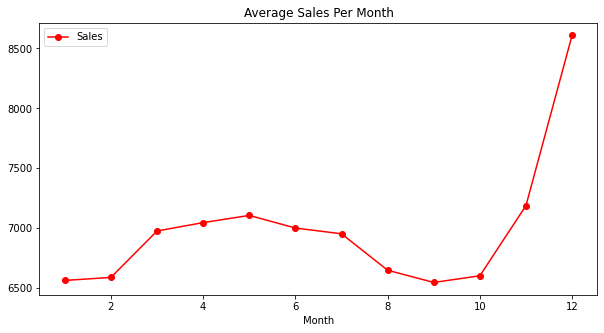

<Figure size 432x288 with 0 Axes>

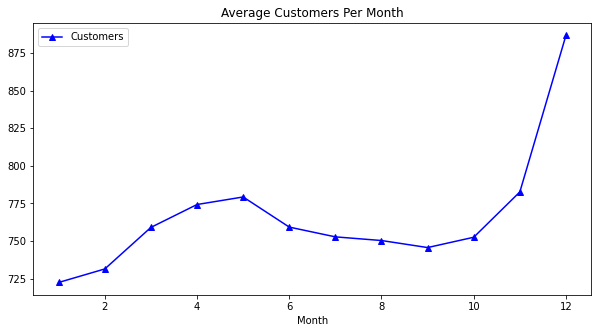

In [41]:
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Month')

plt.figure()
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Month')

************************************************************************
************************************************************************

Let us take a look at the sales and customers per day of the month

We can see that Minimum number of customers are generally around the 24th of the month 

Also, most customers and sales are around 30th and 1st of the month
************************************************************************
************************************************************************



Text(0.5, 1.0, 'Average Sales Per Day')

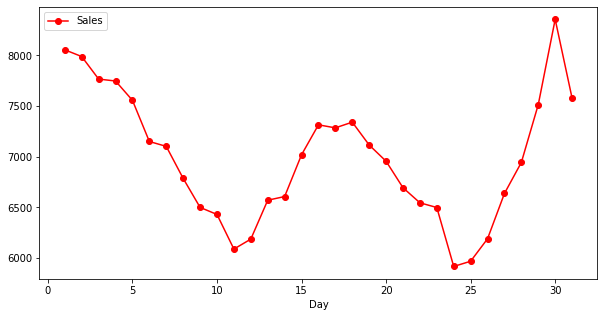

<Figure size 432x288 with 0 Axes>

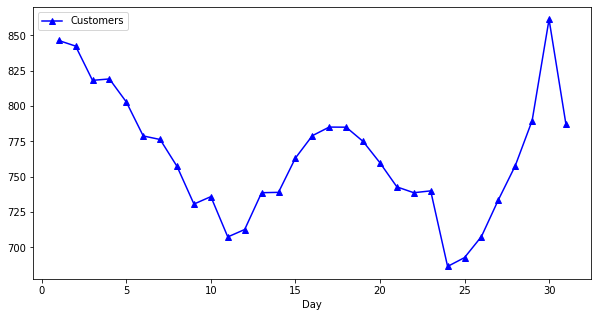

In [42]:
ax = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day')

plt.figure()
ax = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Sales Per Day')

************************************************************************
************************************************************************

Let us take a look at the sales and customers per day of the week

We can see that Minimum number of customers are generally around Saturday 

Also, most customers and sales are on Sunday and Monday
************************************************************************
************************************************************************



Text(0.5, 1.0, 'Average Customers Per Day of the Week')

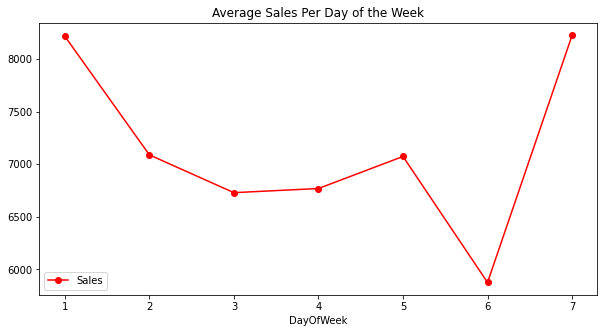

<Figure size 432x288 with 0 Axes>

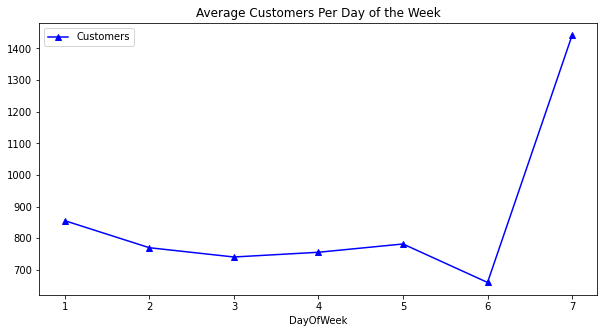

In [43]:
axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day of the Week')

plt.figure()
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Day of the Week')

**BRIEF SUMMARY OF EDA** **:**

************************************************************************
************************************************************************

**1) A strong positive correlation exists between the amount of Sales and Customers of a store.**

**2) A positive correlation exists between the stores that had a Promo equal to 1(stores running promotions) and amount of Customers.**

**3) For observations with Promo2 equal to 1 ( that is for consecutive promotion ), the number of Customers and Sales has a negative correlation.**

**4) Sales and Number of customers peak around christmas timeframe.** 

**5) Minimum number of customers are generally around the 24th of the month.**

**6) Most customers and Sales are around 30th and 1st of the month.**

**7) Minimum number of customers are generally on Saturday.**

**8) Most customers and Sales are on Sunday and Monday.**

************************************************************************
************************************************************************


************************************************************************
************************************************************************
**Handling Categorical features** :
************************************************************************
************************************************************************


In [44]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  int64  
 8   StoreType                  844338 non-null  object 
 9   Assortment                 844338 non-null  object 
 10  CompetitionDistance        844338 non-null  float64
 11  CompetitionOpenSinceMonth  844338 non-null  float64
 12  CompetitionOpenSinceYear   844338 non-null  float64
 13  Promo2                     84

************************************************************************
************************************************************************
**Feature : StateHoliday**
************************************************************************
************************************************************************


In [45]:
set(sales_train_all_df.StateHoliday)

{0, '0', 'a', 'b', 'c'}

************************************************************************
************************************************************************
Let us encode the stateHoliday similarity as follows since only 0 would mean a Non-holiday and rest are holidays :
************************************************************************
************************************************************************


In [46]:
sales_train_all_df["StateHoliday"] = sales_train_all_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
sales_train_all_df['StateHoliday'] = sales_train_all_df['StateHoliday'].astype(int)

In [47]:
sales_train_all_df["StateHoliday"].unique()

array([0, 1])

************************************************************************
************************************************************************
**Feature : PromoInterval**
************************************************************************
************************************************************************


In [48]:
set(sales_train_all_df.PromoInterval)

{0, 'Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'}

In [49]:
sales_train_all_df["PromoInterval"] = sales_train_all_df["PromoInterval"].map({0: 0, "0":0, "Jan,Apr,Jul,Oct":1, "Feb,May,Aug,Nov":2, "Mar,Jun,Sept,Dec":3})
sales_train_all_df['PromoInterval'] = sales_train_all_df['PromoInterval'].astype(int)

In [50]:
sales_train_all_df["PromoInterval"].unique()

array([0, 1, 2, 3])

In [51]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  int64  
 7   SchoolHoliday              844338 non-null  int64  
 8   StoreType                  844338 non-null  object 
 9   Assortment                 844338 non-null  object 
 10  CompetitionDistance        844338 non-null  float64
 11  CompetitionOpenSinceMonth  844338 non-null  float64
 12  CompetitionOpenSinceYear   844338 non-null  float64
 13  Promo2                     84

In [52]:
sales_train_all_df_limited = sales_train_all_df.copy()

In [53]:
#x_pre = sales_train_all_df_limited.drop('Sales', axis=1)
#x_pre = sales_train_all_df_limited.drop(['Sales','Store','Date','CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'] , axis = 1)
x_pre = sales_train_all_df_limited.drop(['Sales','Store','Date'] , axis = 1)

In [54]:
y = sales_train_all_df_limited.Sales

In [55]:
x_pre.head(5)

,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,5,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,4,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,3,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,2,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [56]:
y.head(5)

0    5263
1    5020
2    4782
3    5011
4    6102
Name: Sales, dtype: int64

In [57]:
x = x_pre.copy()

************************************************************************
************************************************************************
Let us get the dummy variables for 'StoreType' and 'Assortment' categorical features before feeding data to machine learning algorithms :
************************************************************************
************************************************************************


In [58]:
#x = pd.get_dummies(x,columns=['StoreType','Assortment'])
x = pd.get_dummies(x)

In [59]:
x.head(5)

,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,...,Year,Month,Day,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,5,555,1,0,1,1270.0,9.0,2008.0,0,0.0,...,2015,7,31,0,0,1,0,1,0,0
1,4,546,1,0,1,1270.0,9.0,2008.0,0,0.0,...,2015,7,30,0,0,1,0,1,0,0
2,3,523,1,0,1,1270.0,9.0,2008.0,0,0.0,...,2015,7,29,0,0,1,0,1,0,0
3,2,560,1,0,1,1270.0,9.0,2008.0,0,0.0,...,2015,7,28,0,0,1,0,1,0,0
4,1,612,1,0,1,1270.0,9.0,2008.0,0,0.0,...,2015,7,27,0,0,1,0,1,0,0


In [60]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=1)

************************************************************************
************************************************************************
**Defining the Error functions :**
************************************************************************
************************************************************************


**Mean Absolute Error (MAE) :**

The MAE is the absolute difference between the data and the model’s predictions. As we just use the absolute value of the residual, the MAE does not indicate underperformance or overperformance of the model. A small MAE suggests the model is great at prediction, while a large MAE suggests that the model has trouble in certain areas. A MAE of 0 means that the model is a perfect predictor of the outputs.

In [61]:
def MAE(y_actual, y_pred):
  return round(np.mean(abs(y_actual-y_pred)),4)

**Mean Absolute Percentage Error (MAPE):**


MAPE Shows how far the prediction is from the actual value, on average, as a percentage

In [62]:
def MAPE(y_actual, y_pred):
    return round(np.mean(np.abs((y_actual - y_pred)/y_actual)),4)

**Root Mean Squared Error (RMSE) :**

RMSE is the square root of the average of squared errors. The effect of each error on RMSE is proportional to the size of the squared error, thus larger errors have a disproportionately large effect on RMSE and aso, RMSE is sensitive to outliers.RMSE is always non-negative, and a value of 0 indicates a perfect fit to the data.

In [63]:
def RMSE(y_actual, y_pred):
    return round(np.sqrt(np.mean(np.square((y_actual - y_pred) ))),4)

**Root Mean Squared Percentage Error (RMSPE):**

RMSPE gives an idea of the magnitude of the error in relation to the actual values.

In [64]:
def RMSPE(y_actual, y_pred):
    return round((np.sqrt(np.mean(np.square((y_actual - y_pred) / y_actual)))) * 100,4)

************************************************************************
************************************************************************
**MACHINE LEARNING MODELS** :
************************************************************************
************************************************************************


************************************************************************
************************************************************************
**1. Average Baseline Model (Model that just calculates the average sales per store)** :
************************************************************************
************************************************************************


In [65]:
base_df = sales_train_all_df.copy()

In [66]:
#calculate the average sales value
base_df_avgsales = base_df[['Store','Sales']].groupby("Store").mean().reset_index().rename(columns = {'Sales':'Average_Sales'})

In [67]:
base_all_df = pd.merge(base_df,base_df_avgsales, how = 'left', on = 'Store')

In [68]:
base_df_y_actual = base_all_df['Sales']
base_df_y_pred = base_all_df['Average_Sales']

#get the error metrics of base average model
base_MAE = MAE(base_df_y_actual, base_df_y_pred)
base_MAPE = MAPE(base_df_y_actual, base_df_y_pred)
base_RMSE = RMSE(base_df_y_actual, base_df_y_pred)
base_RMSPE = RMSPE(base_df_y_actual, base_df_y_pred)

In [69]:
print("Base Model MAE", ":", base_MAE)
print("Base Model MAPE", ":", base_MAPE)
print("Base Model RMSE", ":", base_RMSE)
print("Base Model RMSPE", ":", base_RMSPE)

Base Model MAE : 1456.855
Base Model MAPE : 0.2362
Base Model RMSE : 1957.9119
Base Model RMSPE : 39.3718


************************************************************************
************************************************************************
**2. Linear Regression (Ordinary Least Squares) :**
************************************************************************
************************************************************************


In [70]:
lin_model = LinearRegression()
lin_regression = lin_model.fit(x_train, y_train)
# get predictions for Linear Regression
y_pred_LR = lin_regression.predict(x_train)
y_test_pred_LR = lin_regression.predict(x_test)

In [71]:
train_LR_score = lin_regression.score(x_train, y_train)
test_LR_score = lin_regression.score(x_test, y_test)
train_LR_MAE = MAE(y_train, y_pred_LR)
test_LR_MAE = MAE(y_test, y_test_pred_LR)
train_LR_MAPE = MAPE(y_train, y_pred_LR)
test_LR_MAPE = MAPE(y_test, y_test_pred_LR)
train_LR_RMSE = RMSE(y_train, y_pred_LR)
test_LR_RMSE = RMSE(y_test, y_test_pred_LR)
train_LR_RMSPE = RMSPE(y_train, y_pred_LR)
test_LR_RMSPE = RMSPE(y_test, y_test_pred_LR)

In [72]:
print("Linear Regresion Model Train Score" , ":" , train_LR_score ,"," ,
      "Linear Regresion Model Test Score" ,":" , test_LR_score)
print("Train MAE", ":", train_LR_MAE,"," ,
      "Test MAE", ":", test_LR_MAE)
print("Train MAPE", ":", train_LR_MAPE,"," ,
      "Test MAPE", ":", test_LR_MAPE)
print("Train RMSE", ":", train_LR_RMSE,"," ,
      "Test RMSE", ":", test_LR_RMSE)
print("Training RMSPE", ":", train_LR_RMSPE,"," ,
      "Testing RMSPE", ":", test_LR_RMSPE)

Linear Regresion Model Train Score : 0.826214495661728 , Linear Regresion Model Test Score : 0.8287774206538482
Train MAE : 938.1422 , Test MAE : 934.7298
Train MAPE : 0.1429 , Test MAPE : 0.1426
Train RMSE : 1292.5497 , Test RMSE : 1287.4622
Training RMSPE : 19.1589 , Testing RMSPE : 19.2301


************************************************************************
************************************************************************
**3. Ridge Regression (Linear least squares with l2 regularization) :**
************************************************************************
************************************************************************


In [73]:
#Ridge_l2_regression = RidgeCV(alphas = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01,0.03, 0.1, 0.3, 1, 3, 10, 30, 100]).fit(x_train, y_train)
#Ridge_l2_regression = Ridge_l2_model.fit(x_train, y_train)
Ridge_l2_model = Ridge(alpha = 1)
Ridge_l2_regression = Ridge_l2_model.fit(x_train, y_train)
# get predictions for Linear Regression with L2 regularization
y_pred_LR2 = Ridge_l2_regression.predict(x_train)
y_test_pred_LR2 = Ridge_l2_regression.predict(x_test)

In [74]:
train_LR2_score = Ridge_l2_regression.score(x_train, y_train)
test_LR2_score = Ridge_l2_regression.score(x_test, y_test)
train_LR2_MAE = MAE(y_train, y_pred_LR2)
test_LR2_MAE = MAE(y_test, y_test_pred_LR2)
train_LR2_MAPE = MAPE(y_train, y_pred_LR2)
test_LR2_MAPE = MAPE(y_test, y_test_pred_LR2)
train_LR2_RMSE = RMSE(y_train, y_pred_LR2)
test_LR2_RMSE = RMSE(y_test, y_test_pred_LR2)
train_LR2_RMSPE = RMSPE(y_train, y_pred_LR2)
test_LR2_RMSPE = RMSPE(y_test, y_test_pred_LR2)

In [75]:
print("Ridge Regresion Model Train Score" , ":" , train_LR2_score ,"," ,
      "Ridge Regresion Model Test Score" ,":" , test_LR2_score)
print("Train MAE", ":", train_LR2_MAE,"," ,
      "Test MAE", ":", test_LR2_MAE)
print("Train MAPE", ":", train_LR2_MAPE,"," ,
      "Test MAPE", ":", test_LR2_MAPE)
print("Train RMSE", ":", train_LR2_RMSE,"," ,
      "Test RMSE", ":", test_LR2_RMSE)
print("Training RMSPE", ":", train_LR2_RMSPE,"," ,
      "Testing RMSPE", ":", test_LR2_RMSPE)

Ridge Regresion Model Train Score : 0.8259432865513869 , Ridge Regresion Model Test Score : 0.8285259048331121
Train MAE : 939.6218 , Test MAE : 936.2103
Train MAPE : 0.1432 , Test MAPE : 0.1429
Train RMSE : 1293.5579 , Test RMSE : 1288.4075
Training RMSPE : 19.1795 , Testing RMSPE : 19.2461


************************************************************************
************************************************************************
**4. Lasso Regression (Linear Model trained with L1 prior as regularizer) :**
************************************************************************
************************************************************************


In [76]:
#Lasso_l1_regression = LassoCV(alphas = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01,0.03, 0.1, 0.3, 1, 3, 10, 30, 100]).fit(x_train, y_train)
Lasso_l1_model = Lasso(alpha = 0.01)
Lasso_l1_regression = Lasso_l1_model.fit(x_train, y_train)
# get predictions for Linear Regression with L1 regularization
y_pred_LR1 = Lasso_l1_regression.predict(x_train)
y_test_pred_LR1 = Lasso_l1_regression.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.772e+11, tolerance: 5.682e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [77]:
train_LR1_score = Lasso_l1_regression.score(x_train, y_train)
test_LR1_score = Lasso_l1_regression.score(x_test, y_test)
train_LR1_MAE = MAE(y_train, y_pred_LR1)
test_LR1_MAE = MAE(y_test, y_test_pred_LR1)
train_LR1_MAPE = MAPE(y_train, y_pred_LR1)
test_LR1_MAPE = MAPE(y_test, y_test_pred_LR1)
train_LR1_RMSE = RMSE(y_train, y_pred_LR1)
test_LR1_RMSE = RMSE(y_test, y_test_pred_LR1)
train_LR1_RMSPE = RMSPE(y_train, y_pred_LR1)
test_LR1_RMSPE = RMSPE(y_test, y_test_pred_LR1)

In [78]:
print("Lasso Regresion Model Train Score" , ":" , train_LR1_score ,"," ,
      "Lasso Regresion Model Test Score" ,":" , test_LR1_score)
print("Train MAE", ":", train_LR1_MAE,"," ,
      "Test MAE", ":", test_LR1_MAE)
print("Train MAPE", ":", train_LR1_MAPE,"," ,
      "Test MAPE", ":", test_LR1_MAPE)
print("Train RMSE", ":", train_LR1_RMSE,"," ,
      "Test RMSE", ":", test_LR1_RMSE)
print("Training RMSPE", ":", train_LR1_RMSPE,"," ,
      "Testing RMSPE", ":", test_LR1_RMSPE)

Lasso Regresion Model Train Score : 0.8258386024818438 , Lasso Regresion Model Test Score : 0.8284252702496296
Train MAE : 940.0902 , Test MAE : 936.6873
Train MAPE : 0.1432 , Test MAPE : 0.1429
Train RMSE : 1293.9468 , Test RMSE : 1288.7855
Training RMSPE : 19.1878 , Testing RMSPE : 19.2537


************************************************************************
************************************************************************
**5. Decision Tree :**
************************************************************************
************************************************************************


Before feeding data to Tree based algorithms, let us pre-process the categorical features as before :

In [79]:
xt = x_pre.copy()

In [80]:
yt = sales_train_all_df_limited.Sales

Let us label the 'StoreType' and 'Assortment' categorical features before feeding data to tree based machine learning algorithms :

In [81]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
xt.StateHoliday = label.fit_transform(xt.StateHoliday)
xt.Assortment = label.fit_transform(xt.Assortment)
xt.StoreType = label.fit_transform(xt.StoreType)

In [82]:
xt.head(5)

,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,5,555,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,4,546,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,3,523,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,2,560,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,612,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [83]:
xt_train,xt_test,yt_train,yt_test = train_test_split(xt,yt,test_size=0.3, random_state=1)

In [84]:
dtree_model= DecisionTreeRegressor()
#dtree_regression = dtree_model.fit(xt_train, yt_train)

In [85]:
# Create the parameter grid 
params = {
    'min_samples_leaf': [1, 3, 5]
}

In [86]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dtree_model, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy",return_train_score=True)

In [87]:
grid_search.fit(xt_train, yt_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan nan nan]
  category=UserWarning,


GridSearchCV(cv=4, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 3, 5]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [88]:
#score_df = pd.DataFrame(grid_search.cv_results_)
#score_df.head()

In [89]:
#score_df.nlargest(5,"mean_test_score")

In [90]:
grid_search.best_estimator_

DecisionTreeRegressor()

**After multiple attempts of hyperparameter tuning, we finally arrive at the conclusion that the Decision tree model with the default paramaters has the best model performance and hence using the default model :**

In [91]:
dtree_model= DecisionTreeRegressor()
dtree_regression = dtree_model.fit(xt_train, yt_train)
dtree_regression.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [92]:
y_pred_DT = dtree_regression.predict(xt_train)
y_test_pred_DT = dtree_regression.predict(xt_test)

In [93]:
train_DT_score = dtree_regression.score(xt_train, yt_train)
test_DT_score = dtree_regression.score(xt_test, yt_test)
train_DT_MAE = MAE(yt_train, y_pred_DT)
test_DT_MAE = MAE(yt_test, y_test_pred_DT)
train_DT_MAPE = MAPE(yt_train, y_pred_DT)
test_DT_MAPE = MAPE(yt_test, y_test_pred_DT)
train_DT_RMSE = RMSE(yt_train, y_pred_DT)
test_DT_RMSE = RMSE(yt_test, y_test_pred_DT)
train_DT_RMSPE = RMSPE(yt_train, y_pred_DT)
test_DT_RMSPE = RMSPE(yt_test, y_test_pred_DT)

In [94]:
print("Decision Tree Model Train Score" , ":" , train_DT_score ,"," ,
      "Decision Tree Model Test Score" ,":" , test_DT_score)
print("Train MAE", ":", train_DT_MAE,"," ,
      "Test MAE", ":", test_DT_MAE)
print("Train MAPE", ":", train_DT_MAPE,"," ,
      "Test MAPE", ":", test_DT_MAPE)
print("Train RMSE", ":", train_DT_RMSE,"," ,
      "Test RMSE", ":", test_DT_RMSE)
print("Training RMSPE", ":", train_DT_RMSPE,"," ,
      "Testing RMSPE", ":", test_DT_RMSPE)

Decision Tree Model Train Score : 0.9999995196333464 , Decision Tree Model Test Score : 0.9481023206156011
Train MAE : 0.0084 , Test MAE : 463.437
Train MAPE : 0.0 , Test MAPE : 0.0682
Train RMSE : 2.149 , Test RMSE : 708.8069
Training RMSPE : 0.0557 , Testing RMSPE : 9.5074


************************************************************************
************************************************************************
**Error Distribution of Decision Tree Model :**
************************************************************************
************************************************************************


In [95]:
error_dist_df = xt_test
error_dist_df['y_actual'] = yt_test
error_dist_df['y_pred'] = y_test_pred_DT

In [96]:
error_dist_df['error'] = error_dist_df['y_actual'] - error_dist_df['y_pred']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


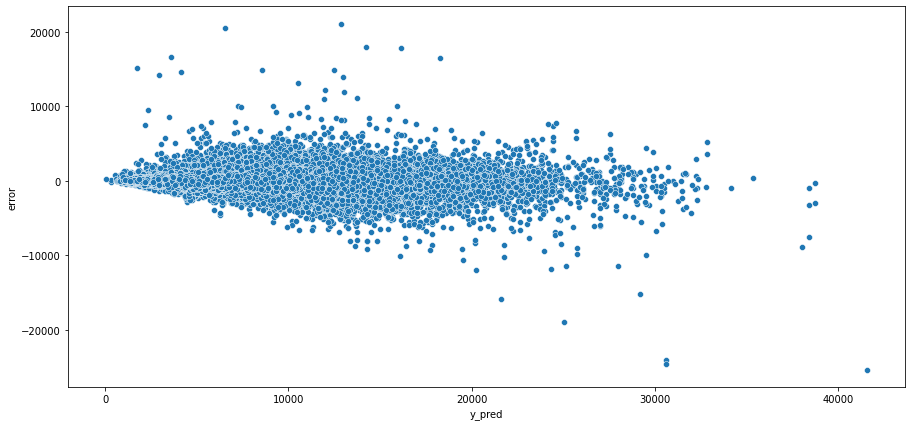

In [97]:
plt.figure(figsize=(15, 7))
sns.scatterplot( error_dist_df['y_pred'], error_dist_df['error'] )

From the above plot, we can observe that there are few stores with higher error. But, majority of the points appear to be in a small horizontal area around zero which indicates that variance in the error is small and centered around zero.

**Observations from Phase 3** :

**1) It is very important to properly process/map the features 'StateHoliday' and 'PromoInterval' before feeding the data to ML algorithms. Before mapping these features, the model scores were all over the place and only after mapping these features, I was able to get reasonable model performances.**

**2) Tree algorithms wont even work if we get the dummy variables for 'StateHoliday','Assortment' and 'StoreType' features. Only after label encoding these features, the decision algorith started to work/give scores.**

**3) After multiple attempts of hyperparameter tuning, we finally arrive at the conclusion that the Decision tree model with the default paramaters has the best model performance.**

**4) The best Decision tree model has a test R2 score of 94.79%, test MAPE of 6.83% and a test RMSPE of 9.49%.**

**5) From the Error distribution plot, we observe that there are few stores with higher error. But, majority of the other points appear to be in a small horizontal area around zero which indicates that variance in the error is small and centered around zero.**

**6) Given below are the comparison of the models used until now :**

In [98]:
train_R2_score=[train_LR_score,train_LR2_score,train_LR1_score,train_DT_score]
test_R2_score=[test_LR_score,test_LR2_score,test_LR1_score,test_DT_score]
train_MAE=[train_LR_MAE,train_LR2_MAE,train_LR1_MAE,train_DT_MAE]
test_MAE=[test_LR_MAE,test_LR2_MAE,test_LR1_MAE,test_DT_MAE]
train_MAPE=[train_LR_MAPE,train_LR2_MAPE,train_LR1_MAPE,train_DT_MAPE]
test_MAPE=[test_LR_MAPE,test_LR2_MAPE,test_LR1_MAPE,test_DT_MAPE]
train_RMSE=[train_LR_RMSE,train_LR2_RMSE,train_LR1_RMSE,train_DT_RMSE]
test_RMSE=[test_LR_RMSE,test_LR2_RMSE,test_LR1_RMSE,test_DT_RMSE]
train_RMSPE=[train_LR_RMSPE,train_LR2_RMSPE,train_LR1_RMSPE,train_DT_RMSPE]
test_RMSPE=[test_LR_RMSPE,test_LR2_RMSPE,test_LR1_RMSPE,test_DT_RMSPE]
col={'Train R2 Score':train_R2_score,'Test R2 Score':test_R2_score,'Train MAE Score':train_MAE,'Test MAE Score':test_MAE,'Train MAPE Score':train_MAPE,'Test MAPE Score':test_MAPE,'Train RMSE Score':train_RMSE,'Test RMSE Score':test_RMSE,'Train RMSPE Score':train_RMSPE,'Test RMSPE Score':test_RMSPE}
models=['Linear Regression','Ridge Regression','Lasso Regression','Decision Tree']
tab_df=pd.DataFrame(data=col,index=models)
print(tab_df)

                   Train R2 Score  Test R2 Score  Train MAE Score  \
Linear Regression        0.826214       0.828777         938.1422   
Ridge Regression         0.825943       0.828526         939.6218   
Lasso Regression         0.825839       0.828425         940.0902   
Decision Tree            1.000000       0.948102           0.0084   

                   Test MAE Score  Train MAPE Score  Test MAPE Score  \
Linear Regression        934.7298            0.1429           0.1426   
Ridge Regression         936.2103            0.1432           0.1429   
Lasso Regression         936.6873            0.1432           0.1429   
Decision Tree            463.4370            0.0000           0.0682   

                   Train RMSE Score  Test RMSE Score  Train RMSPE Score  \
Linear Regression         1292.5497        1287.4622            19.1589   
Ridge Regression          1293.5579        1288.4075            19.1795   
Lasso Regression          1293.9468        1288.7855            19.1

**In the next phase of the project, I will be trying out more complex ML models like XGBoost regressor, Random Forest regressor and if possible, use the deep neural MLP network for sales prediction.**

************************************************************************
************************************************************************
 **Ensemble Techniques**:
************************************************************************
************************************************************************

************************************************************************
************************************************************************
 **Random Forest** :
 ************************************************************************
************************************************************************
 

Random Forest is an ensemble ML model that uses multiple decision trees through a technique called Bootstrapping and Aggregation known as bagging. Random Forest combines multiple decision trees and arrives at final output rather than relying on individual decision trees. 
Random Forest has multiple decision trees as base learning models and rows and features are randomly sampled from the dataset forming sample datasets for every model.

In [99]:
xr_train,xr_test,yr_train,yr_test = train_test_split(xt,yt,test_size=0.3, random_state=1)

In [100]:
rf_model = RandomForestRegressor()
rf_regression = rf_model.fit(xr_train, yr_train)

In [101]:
dtree_regression.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [102]:
# Create the parameter grid
#params = {
#    'bootstrap': [True],
#    'max_depth': [2],
#    'min_samples_leaf': [5],
#    'n_estimators': [10, 50, 100, 200]
#}

In [103]:
# Instantiate the grid search model
#grid_search_rf = GridSearchCV(estimator=rf_model, 
#                           param_grid=params, 
#                           cv=3, n_jobs=-1, verbose=1, scoring = "accuracy",return_train_score=True)

In [104]:
#grid_search_rf.fit(xr_train, yr_train)

In [105]:
#grid_search_rf.best_estimator_

In [106]:
#rf_model= RandomForestRegressor()
#rf_regression = rf_model.fit(xr_train, yr_train)

In [107]:
y_pred_RF = rf_regression.predict(xr_train)
y_test_pred_RF = rf_regression.predict(xr_test)

In [108]:
train_RF_score = dtree_regression.score(xr_train, yr_train)
test_RF_score = dtree_regression.score(xr_test, yr_test)
train_RF_MAE = MAE(yr_train, y_pred_RF)
test_RF_MAE = MAE(yr_test, y_test_pred_RF)
train_RF_MAPE = MAPE(yr_train, y_pred_RF)
test_RF_MAPE = MAPE(yr_test, y_test_pred_RF)
train_RF_RMSE = RMSE(yr_train, y_pred_RF)
test_RF_RMSE = RMSE(yr_test, y_test_pred_RF)
train_RF_RMSPE = RMSPE(yr_train, y_pred_RF)
test_RF_RMSPE = RMSPE(yr_test, y_test_pred_RF)

In [109]:
print("Random Forest Model Train Score" , ":" , train_RF_score ,"," ,
      "Random Forest Model Test Score" ,":" , test_RF_score)
print("Train MAE", ":", train_RF_MAE,"," ,
      "Test MAE", ":", test_RF_MAE)
print("Train MAPE", ":", train_RF_MAPE,"," ,
      "Test MAPE", ":", test_RF_MAPE)
print("Train RMSE", ":", train_RF_RMSE,"," ,
      "Test RMSE", ":", test_RF_RMSE)
print("Training RMSPE", ":", train_RF_RMSPE,"," ,
      "Testing RMSPE", ":", test_RF_RMSPE)

Random Forest Model Train Score : 0.9999995196333464 , Random Forest Model Test Score : 0.9481023206156011
Train MAE : 122.3835 , Test MAE : 329.9142
Train MAPE : 0.0181 , Test MAPE : 0.0487
Train RMSE : 186.7553 , Test RMSE : 499.4189
Training RMSPE : 2.5055 , Testing RMSPE : 6.6389


************************************************************************
************************************************************************
 **We can observe that the Random Forest model performance is better than that of Decision Tree model.**
 ************************************************************************
************************************************************************
 

************************************************************************
************************************************************************
**Error Distribution of Random Forest Model :**
************************************************************************
************************************************************************

In [110]:
error_dist_df_RF = xr_test
error_dist_df_RF['y_actual'] = yr_test
error_dist_df_RF['y_pred'] = y_test_pred_RF

In [111]:
error_dist_df_RF['error'] = error_dist_df_RF['y_actual'] - error_dist_df_RF['y_pred']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


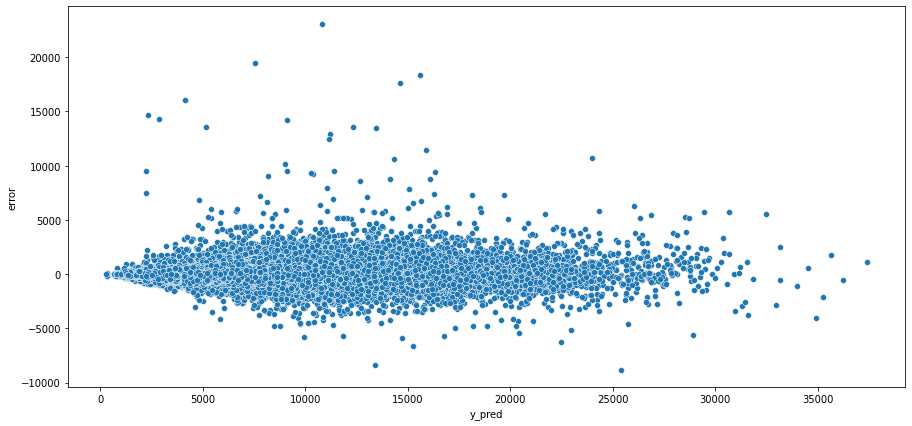

In [112]:
plt.figure(figsize=(15, 7))
sns.scatterplot( error_dist_df_RF['y_pred'], error_dist_df_RF['error'] )

************************************************************************
************************************************************************
 **From the above plot, we can observe that the error distribution is much narrower in Random Forest model than in Decision Tree model and there are few stores with higher error. The variance in the error is smaller than Decision Tree model and centered around zero.**
 ************************************************************************
************************************************************************
 

************************************************************************
************************************************************************
 **XGBoost** :
 ************************************************************************
************************************************************************
 

************************************************************************
************************************************************************
 Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.
Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.
XGBoost expects to have the base learners which are uniformly bad at the remainder so that when all the predictions are combined, bad predictions cancels out and better one sums up to form final good predictions.
************************************************************************
************************************************************************
 

In [114]:
xg_train,xg_test,yg_train,yg_test = train_test_split(xt,yt,test_size=0.3, random_state=1)

In [116]:
xg_model = xgb.XGBRegressor(objective ='reg:linear')
xg_regression = xg_model.fit(xg_train, yg_train)

[09:10:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [117]:
xg_regression.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [118]:
y_pred_XG = xg_regression.predict(xg_train)
y_test_pred_XG = xg_regression.predict(xg_test)

In [119]:
train_XG_score = xg_regression.score(xg_train, yg_train)
test_XG_score = xg_regression.score(xg_test, yg_test)
train_XG_MAE = MAE(yg_train, y_pred_XG)
test_XG_MAE = MAE(yg_test, y_test_pred_XG)
train_XG_MAPE = MAPE(yg_train, y_pred_XG)
test_XG_MAPE = MAPE(yg_test, y_test_pred_XG)
train_XG_RMSE = RMSE(yg_train, y_pred_XG)
test_XG_RMSE = RMSE(yg_test, y_test_pred_XG)
train_XG_RMSPE = RMSPE(yg_train, y_pred_XG)
test_XG_RMSPE = RMSPE(yg_test, y_test_pred_XG)

In [120]:
print("XBGoost Model Train Score" , ":" , train_XG_score ,"," ,
      "XBGoost Model Test Score" ,":" , test_XG_score)
print("Train MAE", ":", train_XG_MAE,"," ,
      "Test MAE", ":", test_XG_MAE)
print("Train MAPE", ":", train_XG_MAPE,"," ,
      "Test MAPE", ":", test_XG_MAPE)
print("Train RMSE", ":", train_XG_RMSE,"," ,
      "Test RMSE", ":", test_XG_RMSE)
print("Training RMSPE", ":", train_XG_RMSPE,"," ,
      "Testing RMSPE", ":", test_XG_RMSPE)

XBGoost Model Train Score : 0.8849876705183609 , XBGoost Model Test Score : 0.8854866955603585
Train MAE : 771.3302 , Test MAE : 771.8178
Train MAPE : 0.1173 , Test MAPE : 0.1173
Train RMSE : 1051.5082 , Test RMSE : 1052.8874
Training RMSPE : 16.6002 , Testing RMSPE : 16.3152


************************************************************************
************************************************************************
**Error Distribution of XGBoost Model :**
************************************************************************
************************************************************************

In [121]:
error_dist_df_XG = xg_test
error_dist_df_XG['y_actual'] = yg_test
error_dist_df_XG['y_pred'] = y_test_pred_XG

In [122]:
error_dist_df_XG['error'] = error_dist_df_XG['y_actual'] - error_dist_df_XG['y_pred']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


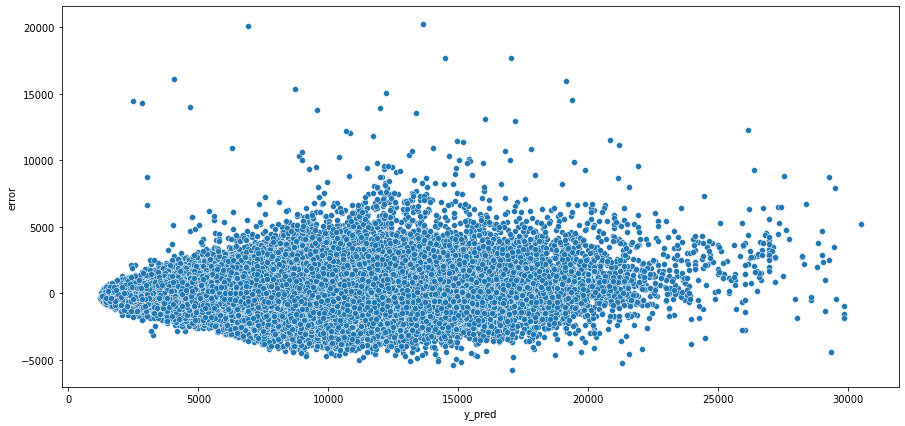

In [123]:
plt.figure(figsize=(15, 7))
sns.scatterplot( error_dist_df_XG['y_pred'], error_dist_df_XG['error'] )

************************************************************************
************************************************************************
 **From the above plot, we can observe that the error distribution of XGBoost model is much wider than Random Forest and Decision Tree models and there are comparitively many stores with higher error. The variance in the error is wider than Decision Tree and Random Forest models, but centered around zero.**
 ************************************************************************
************************************************************************
 

************************************************************************
************************************************************************
 **Deep Learning MLP Model** :
 ************************************************************************
************************************************************************
 

************************************************************************
************************************************************************
 MLP is a neural network for regression/classification tasks.The data flows in a single direction, that is forward, from the input layers to hidden layer(s) and than to output layer. Backpropagation is a technique where the multi-layer perceptron receives feedback on the error in its results and the MLP adjusts its weights accordingly to make more accurate predictions in the future.
 ************************************************************************
************************************************************************
 

In [ ]:
xm_train,xm_test,ym_train,ym_test = train_test_split(xt,yt,test_size=0.3, random_state=1)
xm_train, xm_val, ym_train, ym_val = train_test_split(xm_train, ym_train, test_size=0.1, random_state=1)

In [ ]:
print('Shape of x_train: ', xm_train.shape)
print('Shape of x_val: ', xm_val.shape)
print('Shape of x_test: ', xm_test.shape)
print('Shape of y_train: ', ym_train.shape)
print('Shape of y_val: ', ym_val.shape)
print('Shape of y_test: ', ym_test.shape)

Shape of x_train:  (531932, 17)
Shape of x_val:  (59104, 17)
Shape of x_test:  (253302, 17)
Shape of y_train:  (531932,)
Shape of y_val:  (59104,)
Shape of y_test:  (253302,)


************************************************************************
************************************************************************
 A simple MLP model has a single hidden layer of nodes with an output layer used to make a prediction.
 ************************************************************************
************************************************************************
 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

************************************************************************
************************************************************************
 Here, we need to emphasize on the shape of the input dimension which is equal to the number of features in x train data.
 ************************************************************************
************************************************************************
 

In [ ]:
model = Sequential()
model.add(Dense(50,input_dim = 17,activation="relu"))
model.add(Dense(1,activation = "linear"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                900       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss="mean_absolute_error",metrics=["mean_absolute_error"])

In [ ]:
history1=model.fit(xm_train, ym_train, validation_data=(xm_val, ym_val), epochs=10, batch_size=64)

Epoch 1/10
8312/8312 [==============================] - 17s 2ms/step - loss: 1141.1334 - mean_absolute_error: 1141.1334 - val_loss: 1010.0751 - val_mean_absolute_error: 1010.0751
Epoch 2/10
8312/8312 [==============================] - 15s 2ms/step - loss: 994.4077 - mean_absolute_error: 994.4077 - val_loss: 973.2631 - val_mean_absolute_error: 973.2631
Epoch 3/10
8312/8312 [==============================] - 16s 2ms/step - loss: 962.3558 - mean_absolute_error: 962.3558 - val_loss: 940.3397 - val_mean_absolute_error: 940.3397
Epoch 4/10
8312/8312 [==============================] - 17s 2ms/step - loss: 943.2897 - mean_absolute_error: 943.2897 - val_loss: 932.8172 - val_mean_absolute_error: 932.8172
Epoch 5/10
8312/8312 [==============================] - 15s 2ms/step - loss: 931.6793 - mean_absolute_error: 931.6793 - val_loss: 919.8077 - val_mean_absolute_error: 919.8077
Epoch 6/10
8312/8312 [==============================] - 16s 2ms/step - loss: 923.6132 - mean_absolute_error: 923.6132 - v

************************************************************************
************************************************************************
 Let us plot the loss function as a function of epochs for the training and test sets to see how the network performed as follows :
 ************************************************************************
************************************************************************
 

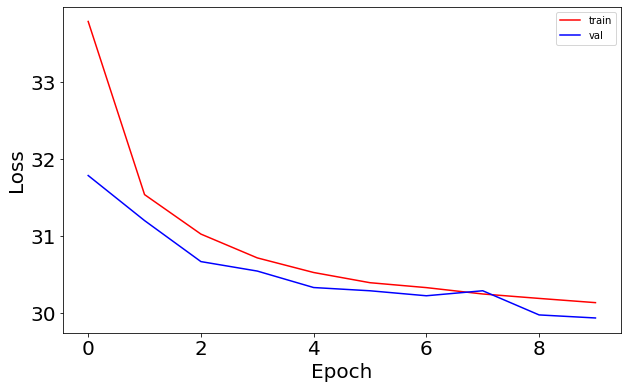

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history1.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history1.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

************************************************************************
************************************************************************
 Let us evaluate the model performance against test data :
 ************************************************************************
************************************************************************
 

In [ ]:
result = model.evaluate(xm_test, ym_test)

7916/7916 [==============================] - 11s 1ms/step - loss: 896.5054 - mean_absolute_error: 896.5054


In [ ]:
y_pred_MLP = model.predict(xm_test)

In [ ]:
test_MLP_score = r2_score(y_pred_MLP, ym_test)

In [ ]:
print("test_MLP_score", ":", test_MLP_score)
for i in range(len(model.metrics_names)): 
    print('Test Data', model.metrics_names[i], ':', round(result[i], 2))

test_MLP_score : 0.7835039934276156
Test Data loss : 896.51
Test Data mean_absolute_error : 896.51


************************************************************************
************************************************************************
 Now, let us increase the number of neurons and see if it changes the model performance :
 ************************************************************************
************************************************************************
 

In [ ]:
model = Sequential()
model.add(Dense(350,input_dim = 17,activation="relu"))
model.add(Dense(1,activation = "linear"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 350)               6300      
                                                                 
 dense_3 (Dense)             (None, 1)                 351       
                                                                 
Total params: 6,651
Trainable params: 6,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss="mean_absolute_error",metrics=["mean_absolute_error"])

In [ ]:
history2=model.fit(xm_train, ym_train, validation_data=(xm_val, ym_val), epochs=10, batch_size=64)

Epoch 1/10
8312/8312 [==============================] - 18s 2ms/step - loss: 1057.5447 - mean_absolute_error: 1057.5447 - val_loss: 1005.4096 - val_mean_absolute_error: 1005.4096
Epoch 2/10
8312/8312 [==============================] - 17s 2ms/step - loss: 949.4464 - mean_absolute_error: 949.4464 - val_loss: 921.1917 - val_mean_absolute_error: 921.1917
Epoch 3/10
8312/8312 [==============================] - 23s 3ms/step - loss: 923.0164 - mean_absolute_error: 923.0164 - val_loss: 907.9913 - val_mean_absolute_error: 907.9913
Epoch 4/10
8312/8312 [==============================] - 29s 3ms/step - loss: 908.1159 - mean_absolute_error: 908.1159 - val_loss: 884.9366 - val_mean_absolute_error: 884.9366
Epoch 5/10
8312/8312 [==============================] - 38s 5ms/step - loss: 897.7511 - mean_absolute_error: 897.7511 - val_loss: 913.2076 - val_mean_absolute_error: 913.2076
Epoch 6/10
8312/8312 [==============================] - 24s 3ms/step - loss: 890.7144 - mean_absolute_error: 890.7144 - v

************************************************************************
************************************************************************
 Let us plot the loss function as a function of epochs for the training and test sets to see how the network performed as follows :
 ************************************************************************
************************************************************************
 

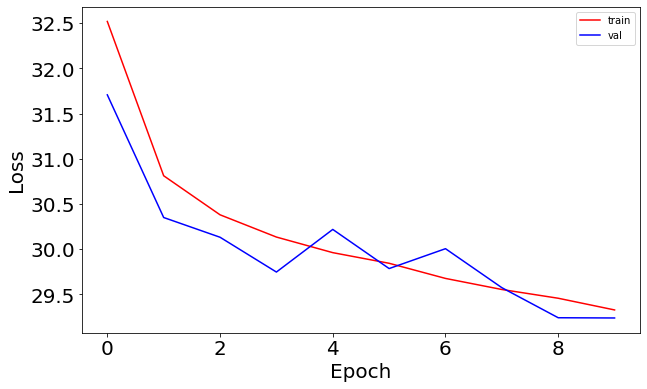

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history2.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history2.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

************************************************************************
************************************************************************
 Let us evaluate the model performance against test data :
 ************************************************************************
************************************************************************
 

In [ ]:
result2 = model.evaluate(xm_test, ym_test)

7916/7916 [==============================] - 12s 2ms/step - loss: 853.5409 - mean_absolute_error: 853.5409


In [ ]:
y_pred_MLP2 = model.predict(xm_test)

In [ ]:
test_MLP_score2 = r2_score(y_pred_MLP2, ym_test)

In [ ]:
print("test_MLP_score", ":", test_MLP_score2)
for i in range(len(model.metrics_names)): 
    print('Test Data', model.metrics_names[i], ':', round(result2[i], 2))

test_MLP_score : 0.8090183403205422
Test Data loss : 853.54
Test Data mean_absolute_error : 853.54


************************************************************************
************************************************************************
 Now, let us create a MLP model with additional set of layers and keeping the number of neurons as 300 as that gave a better model performance earlier :
 ************************************************************************
************************************************************************
 

In [ ]:
model = Sequential()
model.add(Dense(350, input_dim=17, activation='relu'))
model.add(Dense(350, activation='relu'))
model.add(Dense(350, activation='relu'))
model.add(Dense(350, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 350)               6300      
                                                                 
 dense_5 (Dense)             (None, 350)               122850    
                                                                 
 dense_6 (Dense)             (None, 350)               122850    
                                                                 
 dense_7 (Dense)             (None, 350)               122850    
                                                                 
 dense_8 (Dense)             (None, 1)                 351       
                                                                 
Total params: 375,201
Trainable params: 375,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss="mean_absolute_error",metrics=["mean_absolute_error"])

In [ ]:
history3=model.fit(xm_train, ym_train, validation_data=(xm_val, ym_val), epochs=10, batch_size=64)

Epoch 1/10
8312/8312 [==============================] - 78s 9ms/step - loss: 1022.9802 - mean_absolute_error: 1022.9802 - val_loss: 923.8379 - val_mean_absolute_error: 923.8379
Epoch 2/10
8312/8312 [==============================] - 74s 9ms/step - loss: 919.1443 - mean_absolute_error: 919.1443 - val_loss: 882.5878 - val_mean_absolute_error: 882.5878
Epoch 3/10
8312/8312 [==============================] - 75s 9ms/step - loss: 885.8643 - mean_absolute_error: 885.8643 - val_loss: 853.5761 - val_mean_absolute_error: 853.5761
Epoch 4/10
8312/8312 [==============================] - 75s 9ms/step - loss: 861.5185 - mean_absolute_error: 861.5185 - val_loss: 834.8888 - val_mean_absolute_error: 834.8888
Epoch 5/10
8312/8312 [==============================] - 73s 9ms/step - loss: 842.0869 - mean_absolute_error: 842.0869 - val_loss: 819.8806 - val_mean_absolute_error: 819.8806
Epoch 6/10
8312/8312 [==============================] - 75s 9ms/step - loss: 825.4205 - mean_absolute_error: 825.4205 - val

************************************************************************
************************************************************************
 Let us plot the loss function as a function of epochs for the training and test sets to see how the network performed as follows :
 ************************************************************************
************************************************************************
 

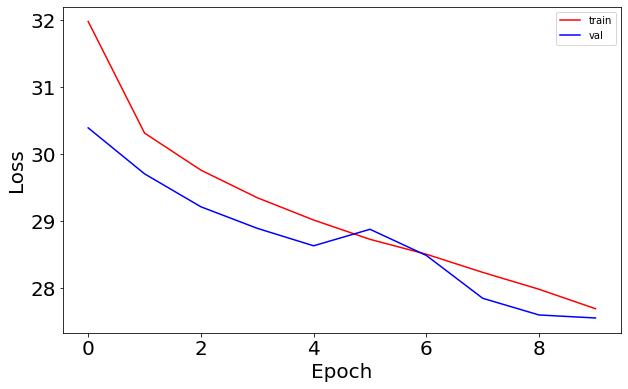

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history3.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history3.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

************************************************************************
************************************************************************
 
Let us evaluate the model performance against test data :
************************************************************************
************************************************************************
 

In [ ]:
result3 = model.evaluate(xm_test, ym_test)

7916/7916 [==============================] - 21s 3ms/step - loss: 757.3890 - mean_absolute_error: 757.3890


In [ ]:
y_pred_MLP3 = model.predict(xm_test)

In [ ]:
test_MLP_score3 = r2_score(y_pred_MLP3, ym_test)

In [ ]:
print("test_MLP_score", ":", test_MLP_score3)
for i in range(len(model.metrics_names)): 
    print('Test Data', model.metrics_names[i], ':', round(result3[i], 2))

test_MLP_score : 0.8546873907288122
Test Data loss : 757.39
Test Data mean_absolute_error : 757.39


************************************************************************
************************************************************************
 When the networks grow deeper, there is a chance of too much of learning from the training data and overfit to it.Dropout is a simple and powerful way to prevent overfitting. Some neurons will be randomly selected and dropped from the network in each layer.Dropout layer needs to be added after activation layer.
 ************************************************************************
************************************************************************
 

In [ ]:
model = Sequential()
model.add(Dense(350, input_dim=17, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 350)               6300      
                                                                 
 dropout (Dropout)           (None, 350)               0         
                                                                 
 dense_10 (Dense)            (None, 350)               122850    
                                                                 
 dropout_1 (Dropout)         (None, 350)               0         
                                                                 
 dense_11 (Dense)            (None, 350)               122850    
                                                                 
 dropout_2 (Dropout)         (None, 350)               0         
                                                                 
 dense_12 (Dense)            (None, 350)              

In [ ]:
model.compile(optimizer='adam',loss="mean_absolute_error",metrics=["mean_absolute_error"])

In [ ]:
history4 = model.fit(xm_train, ym_train, validation_data=(xm_val, ym_val), epochs=10, batch_size=64)

Epoch 1/10
8312/8312 [==============================] - 95s 11ms/step - loss: 1203.6388 - mean_absolute_error: 1203.6388 - val_loss: 930.0569 - val_mean_absolute_error: 930.0569
Epoch 2/10
8312/8312 [==============================] - 90s 11ms/step - loss: 1101.3500 - mean_absolute_error: 1101.3500 - val_loss: 1043.3374 - val_mean_absolute_error: 1043.3374
Epoch 3/10
8312/8312 [==============================] - 90s 11ms/step - loss: 1083.8998 - mean_absolute_error: 1083.8998 - val_loss: 899.0753 - val_mean_absolute_error: 899.0753
Epoch 4/10
8312/8312 [==============================] - 89s 11ms/step - loss: 1071.3413 - mean_absolute_error: 1071.3413 - val_loss: 928.2071 - val_mean_absolute_error: 928.2071
Epoch 5/10
8312/8312 [==============================] - 93s 11ms/step - loss: 1068.6053 - mean_absolute_error: 1068.6053 - val_loss: 881.9928 - val_mean_absolute_error: 881.9928
Epoch 6/10
8312/8312 [==============================] - 91s 11ms/step - loss: 1061.0701 - mean_absolute_erro

************************************************************************
************************************************************************
 Let us plot the loss function as a function of epochs for the training and test sets to see how the network performed as follows :
 ************************************************************************
************************************************************************
 

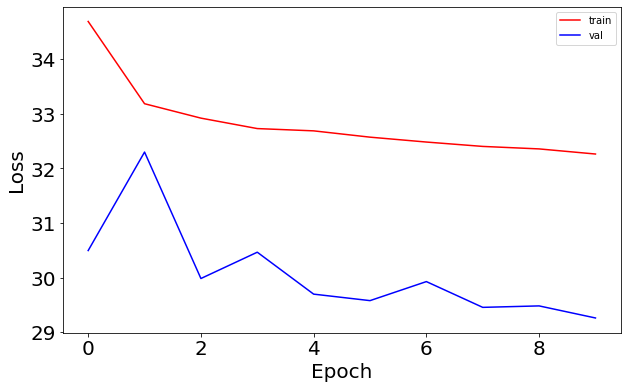

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history4.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history4.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

************************************************************************
************************************************************************
 Let us evaluate the model performance against test data :
 ************************************************************************
************************************************************************
 

In [ ]:
result4 = model.evaluate(xm_test, ym_test)

7916/7916 [==============================] - 22s 3ms/step - loss: 856.7371 - mean_absolute_error: 856.7371


In [ ]:
y_pred_MLP4 = model.predict(xm_test)

In [ ]:
test_MLP_score4 = r2_score(y_pred_MLP4, ym_test)

In [ ]:
print("test_MLP_score", ":", test_MLP_score4)
for i in range(len(model.metrics_names)): 
    print('Test Data', model.metrics_names[i], ':', round(result4[i], 2))

test_MLP_score : 0.8293292282936097
Test Data loss : 856.74
Test Data mean_absolute_error : 856.74


************************************************************************
************************************************************************
**For our current project scenario, since we observe that the model performance of Decision Tree and Random Forest models are better then the MLP neural network,we will use the Decision tree or Random Forest models to deploy the code.**
 ************************************************************************
************************************************************************
 

**Observations from Phase 4**:

**1) For our current case study, We observe that the Random Forest model performance is better than that of Decision Tree model.**

**2) The error distribution of Random Forest model is much narrower than the error distribution of Decision Tree model and there are few stores with higher error. The variance in the error is smaller than Decision Tree model and centered around zero.**

**3) The best Random Forest model has a test R2 score of 94.81% , test MAPE of 4.87% and a test RMSPE of 6.63%.**

**4) The error distribution of XGBoost model is much wider than Random Forest and Decision Tree models and there are comparitively many stores with higher error. The variance in the error is wider than Decision Tree and Random Forest models, but centered around zero.**

**5) A basic MLP neural network with just a single hiden layer consisting of 50 neurons had a score of 78.35 % with MAE of approximately 896.**

**6) When we increased the number of neurons to 350 in this basic MLP network, the score increased to 80.9 % and MAE reduced to approximately 853.**

**7) When we increased the number of hidden layers to 4 with each hidden layer consisting of 350 neurons in the MLP network, the score increased to 85.4 % and MAE reduced to approximately 757.**

**8) When we introduced Dropout layer to this above  MLP network to reduce overfitting , there was no noticeable improvement in model performance.**

**9) For our current project scenario, since we observe that the model performance of Decision Tree and Random Forest models are better then the MLP neural network,we will use the Decision tree or Random Forest models to deploy the code.**

**10) Given below are the comparison of all the models used in our current case study :**

In [124]:
test_r2_mlp  = [0.7835,0.8090,0.8546,0.8293]
test_mae_mlp = [896.51,853.54,757.39,856.74]
col1={'Test R2 Score':test_r2_mlp ,'Test MAE':test_mae_mlp}
models1=['Basic MLP with 50 Nuerons','Basic MLP with 350 Nuerons','MLP with 4 hidden layers','MLP with 4 hidden layers with Dropout']
tab_df1=pd.DataFrame(data=col1,index=models1)
print(tab_df1)

                                       Test R2 Score  Test MAE
Basic MLP with 50 Nuerons                     0.7835    896.51
Basic MLP with 350 Nuerons                    0.8090    853.54
MLP with 4 hidden layers                      0.8546    757.39
MLP with 4 hidden layers with Dropout         0.8293    856.74


In [125]:
train_R2_score=[train_LR_score,train_LR2_score,train_LR1_score,train_DT_score,train_RF_score,train_XG_score]
test_R2_score=[test_LR_score,test_LR2_score,test_LR1_score,test_DT_score,test_RF_score,test_XG_score]
train_MAE=[train_LR_MAE,train_LR2_MAE,train_LR1_MAE,train_DT_MAE,train_RF_MAE,train_XG_MAE]
test_MAE=[test_LR_MAE,test_LR2_MAE,test_LR1_MAE,test_DT_MAE,test_RF_MAE,test_XG_MAE]
train_MAPE=[train_LR_MAPE,train_LR2_MAPE,train_LR1_MAPE,train_DT_MAPE,train_RF_MAPE,train_XG_MAPE]
test_MAPE=[test_LR_MAPE,test_LR2_MAPE,test_LR1_MAPE,test_DT_MAPE,test_RF_MAPE,test_XG_MAPE]
train_RMSE=[train_LR_RMSE,train_LR2_RMSE,train_LR1_RMSE,train_DT_RMSE,train_RF_RMSE,train_XG_RMSE]
test_RMSE=[test_LR_RMSE,test_LR2_RMSE,test_LR1_RMSE,test_DT_RMSE,test_RF_RMSE,test_XG_RMSE]
train_RMSPE=[train_LR_RMSPE,train_LR2_RMSPE,train_LR1_RMSPE,train_DT_RMSPE,train_RF_RMSPE,train_XG_RMSPE]
test_RMSPE=[test_LR_RMSPE,test_LR2_RMSPE,test_LR1_RMSPE,test_DT_RMSPE,test_RF_RMSPE,test_XG_RMSPE]
col={'Train R2 Score':train_R2_score,'Test R2 Score':test_R2_score,'Train MAE':train_MAE,'Test MAE':test_MAE,'Train MAPE':train_MAPE,'Test MAPE':test_MAPE,'Train RMSE':train_RMSE,'Test RMSE':test_RMSE,'Train RMSPE':train_RMSPE,'Test RMSPE':test_RMSPE}
models=['Linear Regression','Ridge Regression','Lasso Regression','Decision Tree','Random Forest','XGBoost Model']
tab_df=pd.DataFrame(data=col,index=models)
print(tab_df)

                   Train R2 Score  Test R2 Score  Train MAE  Test MAE  \
Linear Regression        0.826214       0.828777   938.1422  934.7298   
Ridge Regression         0.825943       0.828526   939.6218  936.2103   
Lasso Regression         0.825839       0.828425   940.0902  936.6873   
Decision Tree            1.000000       0.948102     0.0084  463.4370   
Random Forest            1.000000       0.948102   122.3835  329.9142   
XGBoost Model            0.884988       0.885487   771.3302  771.8178   

                   Train MAPE  Test MAPE  Train RMSE  Test RMSE  Train RMSPE  \
Linear Regression      0.1429     0.1426   1292.5497  1287.4622      19.1589   
Ridge Regression       0.1432     0.1429   1293.5579  1288.4075      19.1795   
Lasso Regression       0.1432     0.1429   1293.9468  1288.7855      19.1878   
Decision Tree          0.0000     0.0682      2.1490   708.8069       0.0557   
Random Forest          0.0181     0.0487    186.7553   499.4189       2.5055   
XGBoost 